# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import random
import math
import json
from collections import defaultdict
from tqdm.notebook import tqdm
from IPython.display import clear_output
import zipfile
import os
from google.colab import files
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
try:
    !pip install trimesh
    import trimesh
    TRIMESH_AVAILABLE = True
except ImportError:
    print("trimesh not available, using fallback for mesh operations.")
    TRIMESH_AVAILABLE = False

try:
    import scipy
    from scipy.spatial import KDTree
    SCIPY_AVAILABLE = True
except ImportError:
    print("Warning: scipy not available, using fallback distance computation.")
    SCIPY_AVAILABLE = False
!pip install scikit-image
SKLEARN_AVAILABLE = True  

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set device and display GPU info
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB")

Using device: cuda
GPU: Tesla P100-PCIE-16GB
GPU Memory: 15 GB


# Globals

In [5]:
# DATASET CONFIGURATION - CHANGE THIS TO SWITCH DATASETS
DATASET_NAME = "synthetic_rooms"  # Using real synthetic_rooms dataset, otherwise "shapenet"

In [6]:
# Dataset configurations
DATASET_CONFIGS = {
    "shapenet": {
        "path": "/kaggle/input/subdataset-random-pick-shapenet-5-gb/ShapeNet",
        "ground_truth_path": None,  # Ground truth in same directory
        "point_cloud_size": 2048,
        "sample_points": 4096,
        "categories": None,  # none loads all categories, otherwise specify
        "file_extension": ".npz",
        "normalize": True
    },
    "synthetic_rooms": {
        "path": "/kaggle/input/synthetic-rooms-04and05/synthetic rooms",  # Fixed path
        "ground_truth_path": "/kaggle/input/gt-rooms-mesh-04and05/gt_rooms_mesh",
        "point_cloud_size": 2048,
        "sample_points": 4096,
        "categories": ['rooms_04', 'rooms_05'], 
        "file_extension": ".npz",
        "normalize": True
    }
}

In [7]:
# Get current dataset config
CURRENT_DATASET = DATASET_CONFIGS[DATASET_NAME]

# Data parameters (dynamically set based on dataset)
BATCH_SIZE = 32 # increased from 4 to 32
INPUT_DIM = 3
OUTPUT_DIM = 1
POINT_CLOUD_SIZE = CURRENT_DATASET["point_cloud_size"]
SAMPLE_POINTS = CURRENT_DATASET["sample_points"]

# Model parameters
ENCODER_C_DIM = 32
PLANE_RESOLUTION = 32 

# Training parameters - FINAL OPTIMIZATION FOR PRECISION
LEARNING_RATE = 3e-4
NUM_EPOCHS = 100 # Increased from 25 to 100
SAVE_INTERVAL = 5
EVAL_INTERVAL = 2 

# Paths (dynamically set based on dataset)
DATA_PATH = CURRENT_DATASET["path"]
MODEL_SAVE_PATH = f"./models/{DATASET_NAME}"
RESULTS_PATH = f"./results/{DATASET_NAME}"

In [8]:
# Create directories if they don't exist
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

# Utils

In [9]:
def set_seed(seed=42):
    """Set random seed for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

def count_parameters(model):
    """Count the number of trainable parameters in a model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [10]:
def normalize_point_cloud(pc):
    """Normalize point cloud to unit sphere"""
    centroid = np.mean(pc, axis=0)
    pc = pc - centroid
    max_dist = np.max(np.sqrt(np.sum(pc**2, axis=1)))
    pc = pc / max_dist
    return pc

In [11]:
def save_checkpoint(model, optimizer, epoch, loss, path):
    """Save model checkpoint"""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)
    print(f"Checkpoint saved at {path}")

def load_checkpoint(model, optimizer, path):
    """Load model checkpoint"""
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['loss']

In [12]:
def validate_dataset_path():
    """Validate that the dataset path exists"""
    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Dataset path {DATA_PATH} does not exist! Please ensure the real dataset is available.")
    return True

def sample_points_on_mesh(vertices, faces, num_points=2048):
    """Sample points from mesh surface"""
    if TRIMESH_AVAILABLE:
        mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
        points, _ = trimesh.sample.sample_surface(mesh, num_points)
        return points
    else:
        # Fallback: random sampling from vertices
        indices = np.random.choice(len(vertices), num_points, replace=True)
        return vertices[indices]

In [13]:
# Zip and download file
def zip_and_download(directory_path, zip_name):
    """Create zip file and download it"""
    with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, file_list in os.walk(directory_path):
            for file in file_list:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, directory_path)
                zipf.write(file_path, arcname)

    files.download(zip_name)  # This 'files' refers to the imported Google Colab module

In [14]:
# optimization utilities
def apply_depthwise_separable_conv(in_channels, out_channels, kernel_size=3):
    """Create depthwise separable convolution layers"""
    return nn.Sequential(
        # Depthwise convolution
        nn.Conv2d(in_channels, in_channels, kernel_size,
                 padding=kernel_size//2, groups=in_channels, bias=False),
        nn.BatchNorm2d(in_channels),
        nn.ReLU(inplace=True),
        # Pointwise convolution
        nn.Conv2d(in_channels, out_channels, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

def prune_model(model, pruning_ratio=0.2):
    """Simple magnitude-based pruning"""
    import torch.nn.utils.prune as prune

    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=pruning_ratio)
    return model

In [15]:
def get_dataset_info():
      """Display current dataset configuration information"""
      print(f"Current dataset: {DATASET_NAME}")
      print(f"Dataset path: {DATA_PATH}")
      print(f"Point cloud size: {POINT_CLOUD_SIZE}")
      print(f"Sample points: {SAMPLE_POINTS}")

## Setup

In [16]:
print("=" * 70)
print("TransONet Convolutional Occupancy Networks for Virtual Scene Generation")
print("=" * 70)

set_seed(42)
print("✓ Random seed set")
get_dataset_info()

TransONet Convolutional Occupancy Networks for Virtual Scene Generation
✓ Random seed set
Current dataset: synthetic_rooms
Dataset path: /kaggle/input/synthetic-rooms-04and05/synthetic rooms
Point cloud size: 2048
Sample points: 4096


# Data

In [17]:
    def _load_synthetic_rooms_files(self):
      """Load Synthetic Rooms file list with correct directory structure"""
      files = []

      # Look for rooms_XX directories
      for room_class in os.listdir(self.data_path):
          room_path = os.path.join(self.data_path, room_class)
          if os.path.isdir(room_path) and room_class.startswith('rooms_'):
              # Look for scene directories (00000000, 00000001, etc.)
              for scene_id in os.listdir(room_path):
                  scene_path = os.path.join(room_path, scene_id)
                  if os.path.isdir(scene_path):
                      # Check if required subdirectories exist
                      pointcloud_dir = os.path.join(scene_path, 'pointcloud')
                      points_iou_dir = os.path.join(scene_path, 'points_iou')

                      if os.path.exists(pointcloud_dir) and os.path.exists(points_iou_dir):
                          files.append(f"{room_class}/{scene_id}")

      print(f"Found {len(files)} files before filtering")  # Debug line

      # Apply train/val split
      np.random.seed(42)  # Fixed seed for consistent splits
      np.random.shuffle(files)
      split_idx = int(0.8 * len(files))

      if self.split == 'train':
          files = files[:split_idx]
      else:
          files = files[split_idx:]

      print(f"After split ({self.split}): {len(files)} files")  # Debug line
      return files

In [18]:
def create_weighted_sampler(dataset, positive_weight_multiplier=10.0):
    from torch.utils.data import WeightedRandomSampler
    
    sample_weights = []
    occupied_samples = 0
    
    for i in tqdm(range(len(dataset)), desc="Computing weights"):
        sample = dataset[i]
        occupancy = sample['occupancy']
        
        if (occupancy > 0.5).any().item():
            positive_ratio = (occupancy > 0.5).float().mean().item()
            weight = positive_weight_multiplier * (1.0 + positive_ratio)
            occupied_samples += 1
        else:
            weight = 1.0
        sample_weights.append(weight)
    
    return WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

def create_data_loaders(batch_size=BATCH_SIZE, use_weighted_sampler=True, positive_weight_multiplier=10.0):
    train_dataset = BaseDataset(DATA_PATH, 'train')
    val_dataset = BaseDataset(DATA_PATH, 'val')

    if use_weighted_sampler:
        train_sampler = create_weighted_sampler(train_dataset, positive_weight_multiplier)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
    else:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader

In [19]:
class BaseDataset(Dataset):
    """Base dataset class for real datasets only"""

    def __init__(self, data_path, split='train', num_sample_points=SAMPLE_POINTS, dataset_type=DATASET_NAME):
        self.data_path = data_path
        self.split = split
        self.num_sample_points = num_sample_points
        self.dataset_type = dataset_type
        self.config = CURRENT_DATASET
        self.has_real_data = os.path.exists(self.data_path)
        
        # Ground truth path for mesh evaluation
        self.ground_truth_path = self.config.get("ground_truth_path", None)
        self.has_ground_truth = self.ground_truth_path and os.path.exists(self.ground_truth_path)

        # Validate dataset exists - fail if not found
        validate_dataset_path()

        # Load data file paths
        self.data_files = self._load_data_files()

        if not self.data_files:
            raise ValueError(f"No data files found for {dataset_type} dataset in {data_path}")

    def _load_data_files(self):
        """Load list of data files based on dataset type"""
        if self.dataset_type == "shapenet":
            return self._load_shapenet_files()
        elif self.dataset_type == "synthetic_rooms":
            return self._load_synthetic_rooms_files()
        else:
            raise ValueError(f"Unknown dataset type: {self.dataset_type}")

    def _load_shapenet_files(self):
        """Load ShapeNet file list"""
        files = []

        if self.has_real_data:
            # Get categories if None, discover all avaiable
            categories = self.config["categories"]
            if categories is None:
                categories = [d for d in os.listdir(self.data_path)
                              if os.path.isdir(os.path.join(self.data_path, d))]

        # Load from actual ShapeNet structure
        for category in categories:
            category_path = os.path.join(self.data_path, category)
            if os.path.exists(category_path):
                split_file = os.path.join(category_path, f"{self.split}.lst")
                if os.path.exists(split_file):
                    with open(split_file, 'r') as f:
                        category_files = [f"{category}/{line.strip()}" for line in f.readlines()]
                        files.extend(category_files)
                else:
                    # If no split file, use all objects in category
                    for obj_id in os.listdir(category_path):
                        obj_path = os.path.join(category_path, obj_id)
                        if os.path.isdir(obj_path):
                            files.append(f"{category}/{obj_id}")

        # Apply train/val split if no predefined split files exist
        if files and not any(os.path.exists(os.path.join(self.data_path, cat, f"{self.split}.lst"))
                           for cat in categories):
            # Random split: 80% train, 20% val
            np.random.seed(42)
            np.random.shuffle(files)
            split_idx = int(0.8 * len(files))

            if self.split == 'train':
                files = files[:split_idx]
            else:
                files = files[split_idx:]

        return files

    def _load_synthetic_rooms_files(self):
        """Load Synthetic Rooms file list with correct directory structure"""
        files = []

        # Look for rooms_XX directories
        for room_class in os.listdir(self.data_path):
            room_path = os.path.join(self.data_path, room_class)
            if os.path.isdir(room_path) and room_class.startswith('rooms_'):
                # Look for scene directories (00000000, 00000001, etc.)
                for scene_id in os.listdir(room_path):
                    scene_path = os.path.join(room_path, scene_id)
                    if os.path.isdir(scene_path):
                        # Check if required subdirectories exist
                        pointcloud_dir = os.path.join(scene_path, 'pointcloud')
                        points_iou_dir = os.path.join(scene_path, 'points_iou')

                        if os.path.exists(pointcloud_dir) and os.path.exists(points_iou_dir):
                            files.append(f"{room_class}/{scene_id}")

        print(f"Found {len(files)} files before filtering")  # Debug line

        # Apply train/val split
        np.random.seed(42)  # Fixed seed for consistent splits
        np.random.shuffle(files)
        split_idx = int(0.8 * len(files))

        if self.split == 'train':
            files = files[:split_idx]
        else:
            files = files[split_idx:]

        print(f"After split ({self.split}): {len(files)} files")  # Debug line
        return files

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        """Get a single data sample - real data only"""
        file_id = self.data_files[idx]

        try:
            return self._load_real_data(file_id)
        except Exception as e:
            raise RuntimeError(f"Failed to load real data for {file_id}: {str(e)}. "
                             f"Ensure the dataset is properly formatted.")

    def _load_real_data(self, file_id):
        """Load real dataset file"""
        if self.dataset_type == "shapenet":
            return self._load_shapenet_sample(file_id)
        elif self.dataset_type == "synthetic_rooms":
            return self._load_synthetic_rooms_sample(file_id)

    def _load_shapenet_sample(self, file_id):
        """Load ShapeNet sample"""
        parts = file_id.split('/')
        category = parts[0]
        hash_id = parts[1]

        # Check nested structure first
        nested_path = os.path.join(self.data_path, category, hash_id)
        file_path = None

        if os.path.isdir(nested_path):
            # Look for .npz files inside the hash directory
            for file in os.listdir(nested_path):
                if file.endswith('.npz'):
                    file_path = os.path.join(nested_path, file)
                    break
        if file_path is None:
            # Fallback to direct file
            file_path = os.path.join(self.data_path, category, f"{hash_id}.npz")

        if not os.path.exists(file_path):
            raise FileNotFoundError(f"ShapeNet file not found: {file_path}")

        # Load the file
        data = np.load(file_path)

        # Extract required fields
        if 'points' not in data:
            raise ValueError(f"No 'points' field found in {file_path}")

        point_cloud = data['points'][:self.config["point_cloud_size"]]

        if len(data['points']) == len(data['occupancies']):
            sample_points = data['points'][:self.num_sample_points]
            occupancy_values = data['occupancies'][:self.num_sample_points]
        else:
            # Generate sample points
            raise ValueError(f"Mismatched data shapes in {file_path}")

        if self.config["normalize"]:
            point_cloud = normalize_point_cloud(point_cloud)
            sample_points = normalize_point_cloud(sample_points)

        return {
            'point_cloud': torch.FloatTensor(point_cloud),
            'sample_points': torch.FloatTensor(sample_points),
            'occupancy': torch.FloatTensor(occupancy_values)
        }

    def _load_synthetic_rooms_sample(self, file_id):
        """Load Synthetic Rooms sample with correct file structure"""
        room_class, scene_id = file_id.split('/')
        scene_path = os.path.join(self.data_path, room_class, scene_id)

        # Load pointcloud data
        pointcloud_dir = os.path.join(scene_path, 'pointcloud')
        pointcloud_files = [f for f in os.listdir(pointcloud_dir) if f.endswith('.npz')]
        if not pointcloud_files:
            raise FileNotFoundError(f"No pointcloud files in {pointcloud_dir}")

        # Use first pointcloud file
        local_rng = np.random.RandomState(hash(file_id) % 2**32)
        pointcloud_path = os.path.join(pointcloud_dir, local_rng.choice(pointcloud_files))
        pointcloud_data = np.load(pointcloud_path)

        # Load points_iou data
        points_iou_dir = os.path.join(scene_path, 'points_iou')
        iou_files = [f for f in os.listdir(points_iou_dir) if f.endswith('.npz')]
        if not iou_files:
            raise FileNotFoundError(f"No IoU files in {points_iou_dir}")

        # Use first IoU file
        iou_path = os.path.join(points_iou_dir, local_rng.choice(iou_files))
        iou_data = np.load(iou_path)

        # Extract data with correct field names
        pc_indices = np.random.choice(len(pointcloud_data['points']), self.config["point_cloud_size"], replace=False)
        point_cloud = pointcloud_data['points'][pc_indices]
        indices = np.random.choice(len(iou_data['points']), self.num_sample_points, replace=False)
        sample_points = iou_data['points'][indices]

        # Unpack occupancy values (they're packed as bits)
        packed_occupancies = iou_data['occupancies']
        occupancy_values = np.unpackbits(packed_occupancies).astype(np.float32)
        occupancy_values = occupancy_values[indices]

        if self.config["normalize"]:
            point_cloud = normalize_point_cloud(point_cloud)
            sample_points = normalize_point_cloud(sample_points)

        # Prepare return data
        sample_data = {
            'point_cloud': torch.FloatTensor(point_cloud),
            'sample_points': torch.FloatTensor(sample_points),
            'occupancy': torch.FloatTensor(occupancy_values),
            'file_id': file_id  # Add file_id for ground truth lookup
        }

        # Load ground truth mesh if available
        if self.has_ground_truth:
            gt_file = os.path.join(self.ground_truth_path, room_class, f"{scene_id}.obj")
            if os.path.exists(gt_file):
                sample_data['ground_truth_mesh_path'] = gt_file

        return sample_data

    def get_ground_truth_mesh_path(self, file_id):
        """Get ground truth mesh path for a specific file_id"""
        if not self.has_ground_truth:
            return None
        
        room_class, scene_id = file_id.split('/')
        gt_file = os.path.join(self.ground_truth_path, room_class, f"{scene_id}.obj")
        
        if os.path.exists(gt_file):
            return gt_file
        
        return None

## Data Loading

In [20]:
print("\n2. DATA LOADING")
print("-" * 40)

train_loader, val_loader = create_data_loaders(
    batch_size=BATCH_SIZE, 
    use_weighted_sampler=True, 
    positive_weight_multiplier=10.0
)

print(f"✓ Train: {len(train_loader.dataset)} samples (weighted sampling)")
print(f"✓ Val: {len(val_loader.dataset)} samples")


2. DATA LOADING
----------------------------------------
Found 2000 files before filtering
After split (train): 1600 files
Found 2000 files before filtering
After split (val): 400 files


Computing weights:   0%|          | 0/1600 [00:00<?, ?it/s]

✓ Train: 1600 samples (weighted sampling)
✓ Val: 400 samples


# Network

In [21]:
class ResNetBlock(nn.Module):
    """ResNet block for PointNet encoder"""
    def __init__(self, c_dim):
        super().__init__()
        self.fc1 = nn.Linear(c_dim, c_dim)
        self.fc2 = nn.Linear(c_dim, c_dim)
        self.bn1 = nn.BatchNorm1d(c_dim)
        self.bn2 = nn.BatchNorm1d(c_dim)
        
    def forward(self, x):
        # x: (B, N, C)
        residual = x
        x = x.transpose(1, 2)  # (B, C, N)
        x = F.relu(self.bn1(self.fc1(x.transpose(1, 2)).transpose(1, 2)))
        x = self.bn2(self.fc2(x.transpose(1, 2)).transpose(1, 2))
        x = x.transpose(1, 2)  # (B, N, C)
        return F.relu(x + residual)

In [22]:
class ResNetPointNet(nn.Module):
    """ResNet PointNet encoder as required by TransONet"""
    def __init__(self, c_dim=32, input_dim=3):
        super().__init__()
        self.c_dim = c_dim
        
        # Initial feature extraction
        self.fc_start = nn.Linear(input_dim, c_dim)
        
        # 5 ResNet blocks as specified in the paper
        self.resnet_blocks = nn.ModuleList([
            ResNetBlock(c_dim) for _ in range(5)
        ])
        
        # Final ResNet block
        self.final_block = ResNetBlock(c_dim)
        
    def forward(self, x):
        # x: (B, N, 3)
        batch_size, num_points, _ = x.shape
        
        # Initial features
        x = self.fc_start(x)  # (B, N, c_dim)
        
        # Pass through ResNet blocks
        for block in self.resnet_blocks:
            x = block(x)
            
        # Final block
        x = self.final_block(x)  # (B, N, c_dim)
        
        return x

In [23]:
class DynamicPlanePredictor(nn.Module):
    """Predicts L dynamic planes with parameters (a,b,c)"""
    def __init__(self, c_dim=32, num_planes=3):
        super().__init__()
        self.num_planes = num_planes
        
        # Simple PointNet for plane prediction
        self.pointnet = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )
        
        # Plane parameter prediction (3 params per plane: a,b,c)
        self.plane_fc = nn.Linear(32, num_planes * 3)
        
        # Plane-specific feature extraction
        self.feature_fc = nn.Linear(32, num_planes * c_dim)
        
    def forward(self, points):
        # points: (B, N, 3)
        batch_size = points.shape[0]
        
        # Extract features
        features = self.pointnet(points)  # (B, N, 32)
        
        # Global max pooling
        global_features = torch.max(features, dim=1)[0]  # (B, 32)
        
        # Predict plane parameters
        plane_params = self.plane_fc(global_features)  # (B, num_planes * 3)
        plane_params = plane_params.view(batch_size, self.num_planes, 3)  # (B, L, 3)
        
        # Normalize to unit vectors
        plane_params = F.normalize(plane_params, p=2, dim=-1)
        
        # Extract plane-specific features
        plane_features = self.feature_fc(global_features)  # (B, num_planes * c_dim)
        plane_features = plane_features.view(batch_size, self.num_planes, -1)  # (B, L, c_dim)
        
        return plane_params, plane_features

In [24]:
class PlanarProjection(nn.Module):
    """Complex planar projection with basis change and normalization"""
    def __init__(self, plane_resolution=64):
        super().__init__()
        self.plane_resolution = plane_resolution
        
    def forward(self, points, features, plane_normals):
        # points: (B, N, 3), features: (B, N, C), plane_normals: (B, L, 3)
        batch_size, num_points, feature_dim = features.shape
        num_planes = plane_normals.shape[1]
        
        projected_features = []
        
        for i in range(num_planes):
            normal = plane_normals[:, i, :]  # (B, 3)
            
            # Project features onto this plane
            plane_features = self._project_to_plane(points, features, normal)
            projected_features.append(plane_features)
        
        return torch.stack(projected_features, dim=1)  # (B, L, H, W, C)
    
    def _project_to_plane(self, points, features, normal):
        # Proper orthogonal projection
        batch_size, num_points, feature_dim  = features.shape

        if normal.dim() == 3:
            normal = normal.squeeze(1) # (B, 3)
            
        # Create orthonormal basis for plane
        # Arbitrary vector not parallele to normal
        arbitrary = torch.tensor([1.0, 0.0, 0.0], device=normal.device)
        
        # Check dot product for each batch item
        dots = torch.abs(torch.sum(normal * arbitrary.unsqueeze(0), dim=-1))  # (B,)
        need_alternate = dots > 0.9
        
        # Use alternate vector where needed
        alternate = torch.tensor([0.0, 1.0, 0.0], device=normal.device)
        arbitrary_batch = torch.where(
            need_alternate.unsqueeze(-1), 
            alternate.unsqueeze(0).expand_as(normal),
            arbitrary.unsqueeze(0).expand_as(normal)
        )
        
        # Gram-Schmidt to get orthonormal basis
        u1 = normal
        u2 = arbitrary.unsqueeze(0).expand_as(normal)
        u2 = u2 - torch.sum(u2 * u1, dim=-1, keepdim=True) * u1
        u2 = F.normalize(u2, dim=-1)

        # Project points onto plane basis
        coords_2d = torch.stack([
            torch.sum(points * u1.unsqueeze(1), dim=-1),
            torch.sum(points * u2.unsqueeze(1), dim=-1)
        ], dim=-1)
        
        # Normalize to [0, plane_resolution-1]
        coords_min = coords_2d.min(dim=1, keepdim=True)[0]
        coords_max = coords_2d.max(dim=1, keepdim=True)[0]
        coords_2d = (coords_2d - coords_min) / (coords_max - coords_min + 1e-8)
        coords_2d = coords_2d * (self.plane_resolution - 1)
        coords_2d = coords_2d.long().clamp(0, self.plane_resolution - 1)
            
        # Create feature map
        feature_map = torch.zeros(
            batch_size, feature_dim, self.plane_resolution, self.plane_resolution,
            device=points.device
        )
        
        # Scatter features
        coords_flat = coords_2d.view(-1, 2)                # Flatten: (B×N, 2)
        features_flat = features.reshape(-1, feature_dim)  # Flatten: (B×N, C)
        batch_indices = torch.arange(batch_size).repeat_interleave(num_points)

        for b in range(batch_size):
            mask = batch_indices == b
            coords_b = coords_flat[mask]
            features_b = features_flat[mask] 
            feature_map[b, :, coords_b[:, 1], coords_b[:, 0]] += features_b.T  # Vectorized
        
        return feature_map

In [25]:
class UNetBlock(nn.Module):
    """U-Net block for processing plane features"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

In [26]:
class PlaneUNet(nn.Module):
    """U-Net for processing plane features"""
    def __init__(self, c_dim=32):
        super().__init__()
        
        # Encoder
        self.enc1 = UNetBlock(c_dim, 64)
        self.enc2 = UNetBlock(64, 128)
        self.enc3 = UNetBlock(128, 256)
        
        # Decoder  
        self.dec3 = UNetBlock(256, 128)
        self.dec2 = UNetBlock(128, 64)
        self.dec1 = UNetBlock(64, c_dim)
        
        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        
        # Decoder
        d3 = self.dec3(e3)
        d2 = self.dec2(self.upsample(d3) + e2)
        d1 = self.dec1(self.upsample(d2) + e1)
        
        return d1

In [27]:
class PositionalEncoding(nn.Module):
    """Positional encoding as used in NeRF and TransONet"""
    def __init__(self, L=10):
        super().__init__()
        self.L = L
        
    def forward(self, x):
        # x: (B, N, 3) -> (B, N, 60)
        encoded = []
        for i in range(self.L):
            encoded.append(torch.sin(2**i * np.pi * x))
            encoded.append(torch.cos(2**i * np.pi * x))
        return torch.cat(encoded, dim=-1)

In [28]:
class TransONetDecoder(nn.Module):
    """TransONet decoder with bilinear interpolation"""
    def __init__(self, c_dim=32, num_planes=3):
        super().__init__()
        self.num_planes = num_planes
        
        # Positional encoding
        self.pos_encoding = PositionalEncoding(L=10)  # 3D -> 60D
        
        # Occupancy prediction network
        self.fc_layers = nn.ModuleList([
            nn.Linear(60 + num_planes * c_dim, c_dim),
            nn.Linear(c_dim, c_dim),
            nn.Linear(c_dim, c_dim),
            nn.Linear(c_dim, 1)
        ])
        
    def forward(self, query_points, plane_features, plane_normals):
        # query_points: (B, M, 3)
        # plane_features: (B, L, C, H, W)
        batch_size, num_queries, _ = query_points.shape
        
        # Apply positional encoding
        pos_encoded = self.pos_encoding(query_points)  # (B, M, 60)
        
        # Sample features from planes using bilinear interpolation
        sampled_features = []
        for i in range(self.num_planes):
            # Project query points to plane i
            plane_coords = self._project_points_to_plane(query_points, plane_normals[:, i, :])
            
            # Sample features using bilinear interpolation
            # plane_features[:, i] is (B, C, H, W) - correct format for grid_sample
            sampled = F.grid_sample(
                plane_features[:, i],  # (B, C, H, W)
                plane_coords.unsqueeze(2),  # (B, M, 1, 2)
                mode='bilinear', padding_mode='border', align_corners=True
            ).squeeze(-1).transpose(1, 2)  # (B, M, C)
            
            sampled_features.append(sampled)
        
        # Concatenate all plane features
        plane_features_concat = torch.cat(sampled_features, dim=-1)  # (B, M, L*C)
        
        # Combine with positional encoding
        features = torch.cat([pos_encoded, plane_features_concat], dim=-1)
        
        # Predict occupancy
        x = features
        for fc in self.fc_layers[:-1]:
            x = F.relu(fc(x))
        raw_logits = self.fc_layers[-1](x)
        occupancy = raw_logits.squeeze(-1)
        
        return occupancy
    
    def _project_points_to_plane(self, points, normal):
        # Simplified projection - real implementation needs proper basis change
        # For now, just use XY coordinates normalized to [-1, 1]
        coords_2d = points[:, :, [0, 1]]  # (B, M, 2)
        return coords_2d

In [29]:
class TransONet(nn.Module):
    """Complete TransONet architecture as required by Project 5"""
    def __init__(self, c_dim=32, num_planes=3, plane_resolution=64):
        super().__init__()
        
        # Components
        self.encoder = ResNetPointNet(c_dim=c_dim)
        self.plane_predictor = DynamicPlanePredictor(c_dim=c_dim, num_planes=num_planes)
        self.planar_projection = PlanarProjection(plane_resolution=plane_resolution)
        self.unet = PlaneUNet(c_dim=c_dim)
        self.decoder = TransONetDecoder(c_dim=c_dim, num_planes=num_planes)
        self.similarity_loss = SimilarityLoss()
        
        print(f"TransONet initialized with {self.count_parameters():,} parameters")
        
    def forward(self, point_cloud, query_points, return_plane_params=False):
        batch_size = point_cloud.shape[0]
        
        # Encode point cloud
        point_features = self.encoder(point_cloud)  # (B, N, c_dim)
        
        # Predict dynamic planes
        plane_normals, plane_features = self.plane_predictor(point_cloud)
        
        # Expand plane features and add to point features
        expanded_plane_features = plane_features.unsqueeze(2).expand(-1, -1, point_features.shape[1], -1)
        point_features_expanded = point_features.unsqueeze(1).expand(-1, plane_normals.shape[1], -1, -1)
        combined_features = point_features_expanded + expanded_plane_features
        
        # Project features onto dynamic planes
        projected_features = []
        for i in range(plane_normals.shape[1]):
            proj_feat = self.planar_projection._project_to_plane(
                point_cloud, combined_features[:, i, :, :], plane_normals[:, i, :]
            )
            projected_features.append(proj_feat)
        
        projected_features = torch.stack(projected_features, dim=1)  # (B, L, C, H, W)
        
        # Process with U-Net
        processed_features = []
        for i in range(plane_normals.shape[1]):
            processed = self.unet(projected_features[:, i, :, :, :])
            processed_features.append(processed)
        
        processed_features = torch.stack(processed_features, dim=1)  # (B, L, C, H, W)
        
        # Decode occupancy
        occupancy = self.decoder(query_points, processed_features, plane_normals)
        
        if return_plane_params:
            return occupancy, plane_normals
        else:
            return occupancy
    
    def compute_loss(self, occupancy_pred, occupancy_true, plane_normals, similarity_weight=0.1):
        # Main occupancy loss
        pos_ratio = occupancy_true.mean()
        pos_weight = (1.0 - pos_ratio) / pos_ratio if pos_ratio > 0 else torch.tensor(100.0)
        pos_weight_tensor = torch.tensor([pos_weight], device=occupancy_true.device)
    
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
        occupancy_loss = criterion(occupancy_pred, occupancy_true)
        
        # Similarity loss for plane diversity
        sim_loss = self.similarity_loss(plane_normals)
        
        total_loss = occupancy_loss + similarity_weight * sim_loss
        return total_loss, occupancy_loss, sim_loss
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def compute_similarity_loss(self, plane_normals):
        return self.similarity_loss(plane_normals)

In [30]:
class SimilarityLoss(nn.Module):
    """Similarity loss to ensure plane diversity"""
    def __init__(self):
        super().__init__()
        
    def forward(self, plane_normals):
        # plane_normals: (B, L, 3)
        batch_size, num_planes, _ = plane_normals.shape
        
        # Compute pairwise dot products
        similarity = torch.bmm(plane_normals, plane_normals.transpose(1, 2))  # (B, L, L)
        
        # Remove diagonal (self-similarity)
        mask = torch.eye(num_planes, device=plane_normals.device).unsqueeze(0)
        similarity = similarity * (1 - mask)
        
        # Penalize high similarity (want diverse planes)
        loss = torch.mean(torch.abs(similarity))
        return loss

# Train

In [31]:
class Trainer:
    """Training class for Transonet"""

    def __init__(self, model, optimizer, device, loss_fn=None, 
             patience=10, min_delta=1e-4, scheduler_type='ReduceLROnPlateau', 
             scheduler_patience=5, scheduler_factor=0.5):
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.criterion = loss_fn or nn.BCEWithLogitsLoss()

        # Training metrics
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

        # Early stopping parameters
        self.patience = patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.epochs_without_improvement = 0
        self.early_stopped = False
        self.best_model_state = None

        # Learning rate scheduler step
        self.scheduler_type = scheduler_type
        if scheduler_type == 'ReduceLROnPlateau':
            self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=scheduler_factor, 
                patience=scheduler_patience, verbose=True, min_lr=1e-7
            )
        elif scheduler_type == 'StepLR':
            self.scheduler = optim.lr_scheduler.StepLR(
                optimizer, step_size=scheduler_patience, gamma=scheduler_factor
            )
        elif scheduler_type == 'CosineAnnealingLR':
            self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
                optimizer, T_max=50, eta_min=1e-7
            )
        else:
            self.scheduler = None
            print(f"Warning: Unknown scheduler type {scheduler_type}, using no scheduler")

    def validate(self, val_loader):
        """Validate the model"""
        self.model.eval()
        total_loss = 0
        total_samples = 0
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for batch in val_loader:
                point_cloud = batch['point_cloud'].to(self.device)
                sample_points = batch['sample_points'].to(self.device)
                occupancy = batch['occupancy'].to(self.device)

                # Handle TransONet dual output
                occupancy_logits, plane_params = self.model(point_cloud, sample_points, return_plane_params=True)

                # Calculate pos_weight
                pos_ratio = occupancy.mean()
                pos_weight = (1.0 - pos_ratio) / pos_ratio if pos_ratio > 0 else torch.tensor(100.0)
                pos_weight_tensor = torch.tensor([pos_weight], device=self.device)

                # Use BCE with pos_weight
                criterion_with_posweight = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
                occ_loss = criterion_with_posweight(occupancy_logits, occupancy)

                # Add similarity loss
                sim_loss = self.model.compute_similarity_loss(plane_params)
                loss = occ_loss + 0.1 * sim_loss
            
                # Statistics
                total_loss += loss.item() * point_cloud.size(0)
                total_samples += point_cloud.size(0)

                # Collect predictions and targets for sklearn metrics
                predictions = torch.sigmoid(occupancy_logits) > 0.5
                all_predictions.append(predictions.cpu().numpy().flatten())
                all_targets.append(occupancy.cpu().numpy().flatten())
            

        # Convert to numpy arrays for sklearn
        all_predictions = np.concatenate(all_predictions)
        all_targets = np.concatenate(all_targets)
        
        # Use sklearn metrics
        accuracy = accuracy_score(all_targets, all_predictions)
    
        avg_loss = total_loss / total_samples
        return avg_loss, accuracy

    def check_early_stopping(self, val_loss):
        """Check if training should stop early and update best model"""
        improved = False
        
        if val_loss < self.best_val_loss - self.min_delta:
            self.best_val_loss = val_loss
            self.epochs_without_improvement = 0
            self.best_model_state = self.model.state_dict().copy()
            improved = True
            print(f"✓ New best validation loss: {val_loss:.6f}")
        else:
            self.epochs_without_improvement += 1
            
        if self.epochs_without_improvement >= self.patience:
            self.early_stopped = True
            print(f"🛑 Early stopping triggered! No improvement for {self.patience} epochs")
            if self.best_model_state is not None:
                self.model.load_state_dict(self.best_model_state)
                print("📁 Restored best model weights")
        
        return improved

    def train(self, train_loader, val_loader, num_epochs):
        print("Starting training...")
        print(f"Model parameters: {count_parameters(self.model):,}")
        print(f"Early stopping: patience={self.patience}, min_delta={self.min_delta}")
        print(f"LR Scheduler: {self.scheduler_type}")

        best_val_loss = float('inf')

        # Progress bar for epochs
        epoch_pbar = tqdm(range(num_epochs), desc="Training Progress")

        for epoch in epoch_pbar:
            start_time = time.time()

            # Train with batch progress bar
            train_loss, train_acc = self.train_epoch_with_progress(train_loader, epoch)
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)

            # Validate
            val_loss, val_acc = self.validate(val_loader)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            # Early stopping
            improved = self.check_early_stopping(val_loss)

            if self.scheduler:
                if self.scheduler_type == 'ReduceLROnPlateau':
                    self.scheduler.step(val_loss)
                else:
                    self.scheduler.step()
                    
                current_lr = self.optimizer.param_groups[0]['lr']
                if improved:
                    print(f"📈 Current LR: {current_lr:.8f}")

            # Real-time plotting
            self.plot_live_progress()

            # Update progress bar
            epoch_pbar.set_postfix({
                'Train_Loss': f'{train_loss:.4f}',
                'Val_Loss': f'{val_loss:.4f}',
                'Train_Acc': f'{train_acc:.4f}',
                'Val_Acc': f'{val_acc:.4f}'
            })

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                save_checkpoint(self.model, self.optimizer, epoch, val_loss,
                            os.path.join(MODEL_SAVE_PATH, 'best_model.pth'))

            if self.early_stopped:
                print(f"🏁 Training stopped early at epoch {epoch+1}")
                break

        # Training completion summary
        if not self.early_stopped:
            print(f"✅ Training completed normally after {num_epochs} epochs")
        
        final_lr = self.optimizer.param_groups[0]['lr']
        print(f"📊 Final LR: {final_lr:.8f}")
        print(f"🎯 Best validation loss: {self.best_val_loss:.6f}")

    def plot_live_progress(self):
        clear_output(wait=True)
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Loss plot
        axes[0].plot(self.train_losses, label='Train Loss', color='blue')
        if self.val_losses:
            val_epochs = list(range(len(self.val_losses)))
            axes[0].plot(val_epochs, self.val_losses, label='Val Loss', color='red')

            if hasattr(self, 'best_val_loss') and self.best_val_loss != float('inf'):
                axes[0].axhline(y=self.best_val_loss, color='green', linestyle='--', alpha=0.7, label=f'Best Val: {self.best_val_loss:.4f}')
        
        axes[0].set_title('Loss Progress')
        axes[0].legend()
        axes[0].grid(True)

        # Accuracy plot
        axes[1].plot(self.train_accuracies, label='Train Acc', color='blue')
        if self.val_accuracies:
            val_epochs = list(range(len(self.val_accuracies)))
            axes[1].plot(val_epochs, self.val_accuracies, label='Val Acc', color='red')
        axes[1].set_title('Accuracy Progress')
        axes[1].legend()
        axes[1].grid(True)

        plt.tight_layout()
        plt.show()

    def train_epoch_with_progress(self, train_loader, epoch):
        self.model.train()
        total_loss = 0
        total_samples = 0
        correct_predictions = 0

        batch_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)

        for batch_idx, batch in enumerate(batch_pbar):
            point_cloud = batch['point_cloud'].to(self.device)
            sample_points = batch['sample_points'].to(self.device)
            occupancy = batch['occupancy'].to(self.device)

            self.optimizer.zero_grad()
            occupancy_logits, plane_normals = self.model(point_cloud, sample_points, return_plane_params=True)
            loss, occ_loss, sim_loss = self.model.compute_loss(
                occupancy_logits, occupancy, plane_normals
            )
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item() * point_cloud.size(0)
            total_samples += point_cloud.size(0)

            predictions = torch.sigmoid(occupancy_logits) > 0.5
            correct_predictions += (predictions == occupancy).sum().item()

            batch_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

        avg_loss = total_loss / total_samples
        accuracy = correct_predictions / (total_samples * SAMPLE_POINTS)
        return avg_loss, accuracy

In [32]:
class TransONetTrainer(Trainer):
    """Enhanced trainer for TransONet with similarity loss"""
    
    def __init__(self, model, optimizer, device, loss_fn=None, similarity_loss_weight=0.1,
                 patience=10, min_delta=1e-4, scheduler_type='ReduceLROnPlateau', 
                 scheduler_patience=5, scheduler_factor=0.5):
        super().__init__(model, optimizer, device, loss_fn, patience, min_delta, 
                         scheduler_type, scheduler_patience, scheduler_factor)
        self.similarity_loss_weight = similarity_loss_weight
        self.similarity_losses = []
    
    def train_epoch_with_progress(self, train_loader, epoch):
        """Train epoch with similarity loss"""
        self.model.train()
        total_loss = 0
        total_occ_loss = 0
        total_sim_loss = 0
        total_samples = 0
        all_predictions = []
        all_targets = []

        batch_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)

        for batch_idx, batch in enumerate(batch_pbar):
            point_cloud = batch['point_cloud'].to(self.device)
            sample_points = batch['sample_points'].to(self.device)
            occupancy = batch['occupancy'].to(self.device)

            self.optimizer.zero_grad()
            
            # Handle TransONet dual output
            occupancy_logits, plane_params = self.model(
                point_cloud, sample_points, return_plane_params=True
            )

            # Calculate pos_weight 
            pos_ratio = occupancy.mean()
            pos_weight = (1.0 - pos_ratio) / pos_ratio if pos_ratio > 0 else torch.tensor(100.0)
            pos_weight_tensor = torch.tensor([pos_weight], device=self.device)

            # Use BCE with pos_weight
            criterion_with_posweight = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
            occ_loss = criterion_with_posweight(occupancy_logits, occupancy)
                    
            # Similarity loss (encourage diverse plane orientations)
            sim_loss = self.model.compute_similarity_loss(plane_params)

            loss = occ_loss + 0.1 * sim_loss
            
            loss.backward()
            self.optimizer.step()

            # Statistics
            total_loss += loss.item() * point_cloud.size(0)
            total_samples += point_cloud.size(0)

            predictions = torch.sigmoid(occupancy_logits) > 0.5
            all_predictions.append(predictions.cpu().numpy().flatten())
            all_targets.append(occupancy.cpu().numpy().flatten())

            batch_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

        all_predictions_flat = np.concatenate(all_predictions)
        all_targets_flat = np.concatenate(all_targets)
        accuracy = accuracy_score(all_targets_flat, all_predictions_flat)

        avg_loss = total_loss / total_samples        
        return avg_loss, accuracy

## Model Creation

In [33]:
def create_transonet_model_and_optimizer():
    """Create TransONet model and optimizer"""
    model = TransONet(
        c_dim=32,
        num_planes=3,
        plane_resolution=64
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    print(f"TransONet created with {count_parameters(model):,} parameters")
    return model, optimizer

In [34]:
print("\n3. MODEL CREATION")
print("-" * 40)

model, optimizer = create_transonet_model_and_optimizer()
model.decoder.fc_layers[-1].bias.data.fill_(0.02) # Bias to avoid collapse to 0 of predictions 
# trying to lower bias from 0.055 to 0.02
print("✓ Model created")


3. MODEL CREATION
----------------------------------------
TransONet initialized with 1,772,298 parameters
TransONet created with 1,772,298 parameters
✓ Model created


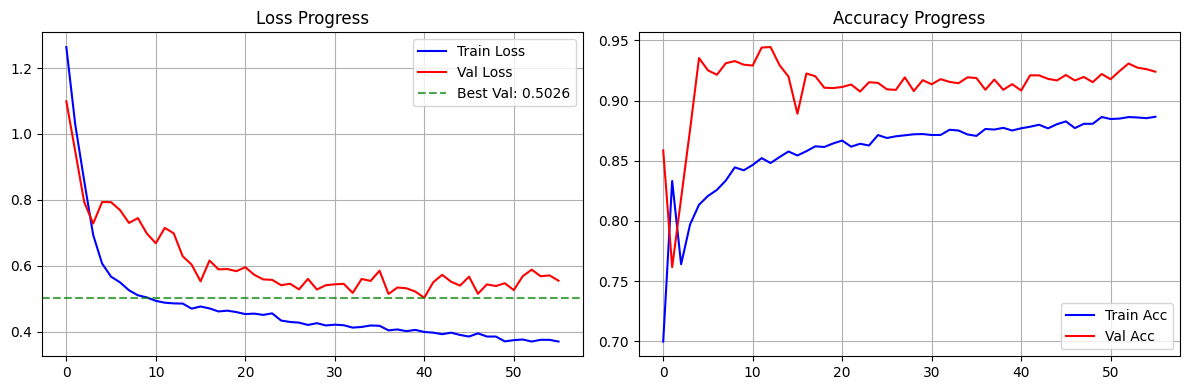

🏁 Training stopped early at epoch 56
📊 Final LR: 0.00002500
🎯 Best validation loss: 0.502587


In [35]:
print("\n4. TRAINING WITH TRANSONET ARCHITECTURE")
print("-" * 60)
print("🚀 Creating TransONet model:")
print("  ✓ ResNet PointNet encoder")
print("  ✓ Dynamic plane predictor")  
print("  ✓ U-Net processing")
print("  ✓ Positional encoding")
print("  ✓ Similarity loss")

trainer = Trainer(model, optimizer, device,
                patience=15,              # Stop after 15 epochs without improvement
                min_delta=1e-5,          # Minimum improvement threshold
                scheduler_type='ReduceLROnPlateau',  # Options: 'ReduceLROnPlateau', 'StepLR', 'CosineAnnealingLR'
                scheduler_patience=7,     # Reduce LR after 7 epochs without improvement
                scheduler_factor=0.5      # Reduce LR by half
                )
trainer.train(train_loader, val_loader, NUM_EPOCHS)

In [36]:
def plot_training_curves(trainer):
    """Plot training and validation curves"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Loss curves
    axes[0].plot(trainer.train_losses, label='Train Loss')
    if trainer.val_losses:
        val_epochs = [i * EVAL_INTERVAL for i in range(len(trainer.val_losses))]
        axes[0].plot(val_epochs, trainer.val_losses, label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Accuracy curves
    axes[1].plot(trainer.train_accuracies, label='Train Accuracy')
    if trainer.val_accuracies:
        val_epochs = [i * EVAL_INTERVAL for i in range(len(trainer.val_accuracies))]
        axes[1].plot(val_epochs, trainer.val_accuracies, label='Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, 'training_curves.png'), dpi=300, bbox_inches='tight')
    plt.show()


5. TRAINING CURVES
----------------------------------------


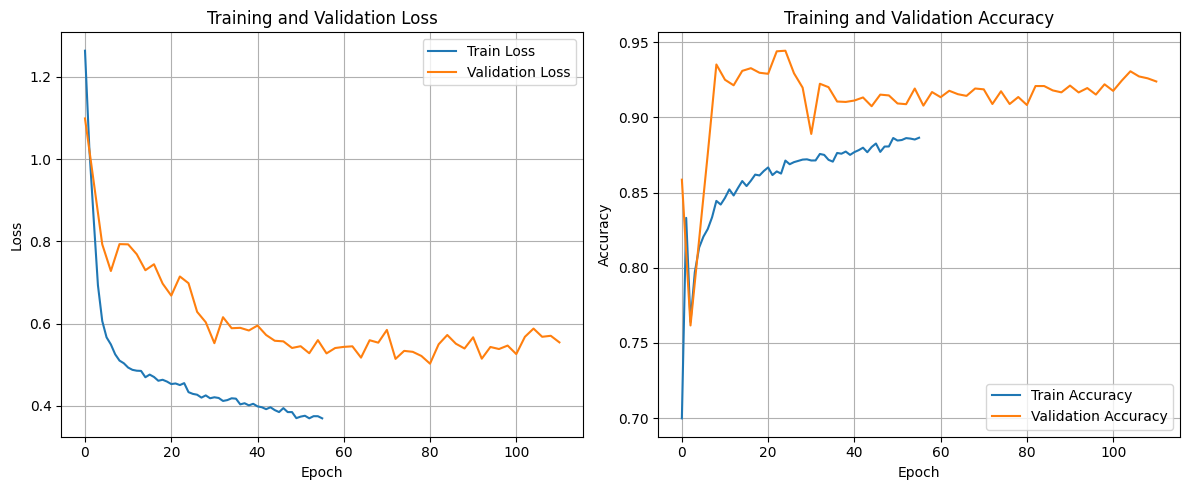

✓ Plots generated


In [37]:
print("\n5. TRAINING CURVES")
print("-" * 40)

plot_training_curves(trainer)
print("✓ Plots generated")

# Test

In [38]:
class TransONetEvaluator:
    """Proper evaluator for TransONet occupancy predictions"""
    
    def __init__(self, model, device):
        self.model = model
        self.device = device
    
    def evaluate_occupancy_metrics(self, test_loader):
        """Evaluate occupancy prediction metrics"""
        self.model.eval()
        
        all_predictions = []
        all_targets = []
        inference_times = []
        
        with torch.no_grad():
            for batch in test_loader:
                point_cloud = batch['point_cloud'].to(self.device)
                sample_points = batch['sample_points'].to(self.device) 
                occupancy = batch['occupancy'].to(self.device)
                
                # Measure inference time
                start_time = time.time()
                occupancy_logits = self.model(point_cloud, sample_points)
                inference_time = time.time() - start_time
                inference_times.append(inference_time)
                
                # Convert logits to predictions
                predictions = torch.sigmoid(occupancy_logits) > 0.5
                
                all_predictions.append(predictions.cpu().numpy().flatten())
                all_targets.append(occupancy.cpu().numpy().flatten())
        
        # Flatten arrays
        all_predictions = np.concatenate(all_predictions)
        all_targets = np.concatenate(all_targets)
        
        # Core occupancy metrics
        accuracy = accuracy_score(all_targets, all_predictions)
        
        # Handle edge cases with sklearn's zero_division parameter
        if all_predictions.sum() > 0:
            precision = precision_score(all_targets, all_predictions, zero_division=0)
        else:
            precision = 0.0

        if all_targets.sum() > 0:
            recall = recall_score(all_targets, all_predictions, zero_division=0)
            f1 = f1_score(all_targets, all_predictions, zero_division=0)
        else:
            recall = f1 = 0.0
        
        # Volumetric IoU (more appropriate for occupancy)
        intersection = ((all_predictions == 1) & (all_targets == 1)).sum()
        union = ((all_predictions == 1) | (all_targets == 1)).sum()
        volumetric_iou = intersection / union if union > 0 else 0
        
        return {
            'occupancy_accuracy': accuracy,
            'occupancy_precision': precision,
            'occupancy_recall': recall,
            'occupancy_f1': f1,
            'volumetric_iou': volumetric_iou,
            'avg_inference_time': np.mean(inference_times),
            'std_inference_time': np.std(inference_times),
            'throughput': len(test_loader.dataset) / sum(inference_times)
        }
    
    def evaluate_mesh_quality(self, test_loader, resolution=64):
        """Evaluate mesh quality if ground truth meshes available"""
        # Only run if ground truth meshes are available
        dataset = test_loader.dataset
        if not hasattr(dataset, 'has_ground_truth') or not dataset.has_ground_truth:
            return {}
        
        self.model.eval()
        mesh_metrics = []
        
        with torch.no_grad():
            for i, batch in enumerate(test_loader):
                if i >= 10:  # Limit for computational efficiency
                    break
                    
                point_cloud = batch['point_cloud'].to(self.device)
                file_id = batch.get('file_id', [None])[0]
                
                if file_id is None:
                    continue
                
                # Generate occupancy field
                occupancy_field = self._generate_occupancy_field(point_cloud, resolution)
                
                # Extract mesh using marching cubes (if trimesh available)
                try:
                    import trimesh
                    from skimage.measure import marching_cubes
                    
                    verts, faces, _, _ = marching_cubes(occupancy_field, level=0.5)
                    predicted_mesh = trimesh.Trimesh(vertices=verts, faces=faces)
                    
                    # Load ground truth mesh
                    gt_mesh_path = dataset.get_ground_truth_mesh_path(file_id)
                    if gt_mesh_path and os.path.exists(gt_mesh_path):
                        gt_mesh = trimesh.load(gt_mesh_path)
                        
                        # Compute mesh metrics
                        metrics = self._compute_mesh_metrics(predicted_mesh, gt_mesh)
                        mesh_metrics.append(metrics)
                        
                except ImportError:
                    print("Trimesh not available for mesh evaluation")
                    break
        
        if mesh_metrics:
            return {
                'mesh_hausdorff_distance': np.mean([m['hausdorff'] for m in mesh_metrics]),
                'mesh_chamfer_distance': np.mean([m['chamfer'] for m in mesh_metrics]),
                'mesh_volume_error': np.mean([m['volume_error'] for m in mesh_metrics])
            }
        return {}
    
    def _generate_occupancy_field(self, point_cloud, resolution):
        """Generate 3D occupancy field for mesh extraction"""
        # Create regular grid
        coords = np.linspace(-1, 1, resolution)
        grid_x, grid_y, grid_z = np.meshgrid(coords, coords, coords, indexing='ij')
        query_points = np.stack([grid_x, grid_y, grid_z], axis=-1).reshape(-1, 3)
        
        # Process in batches to avoid memory issues
        batch_size = 10000
        occupancy_values = []
        
        for i in range(0, len(query_points), batch_size):
            point_cloud_single = point_cloud[:1]  
            batch_points = torch.FloatTensor(query_points[i:i+batch_size]).unsqueeze(0).to(self.device)
            logits = self.model(point_cloud_single, batch_points)
            occupancy = torch.sigmoid(logits) > 0.5
            occupancy_values.append(occupancy.cpu().numpy().flatten())
        
        occupancy_field = np.concatenate(occupancy_values).reshape(resolution, resolution, resolution)
        return occupancy_field.astype(float)
    
    def _compute_mesh_metrics(self, pred_mesh, gt_mesh):
        """Compute mesh-to-mesh distance metrics"""
        if pred_mesh.volume < 0:
            pred_mesh.invert()
        
        # Normalize both to unit scale and center
        pred_mesh.apply_scale(1.0 / pred_mesh.scale)
        gt_mesh.apply_scale(1.0 / gt_mesh.scale)
        
        pred_mesh.vertices -= pred_mesh.centroid
        gt_mesh.vertices -= gt_mesh.centroid
    
        try:
            pred_points, _ = pred_mesh.sample(1000)
            gt_points, _ = gt_mesh.sample(1000)
            
            if pred_points.ndim == 1:
                pred_points = pred_points.reshape(1, -1)
            if gt_points.ndim == 1:
                gt_points = gt_points.reshape(1, -1)
                
        except:
            pred_points = pred_mesh.vertices[:1000]
            gt_points = gt_mesh.vertices[:1000]
            
        # Compute distances
        from scipy.spatial.distance import cdist
        
        # Hausdorff distance
        dist_pred_to_gt = cdist(pred_points, gt_points).min(axis=1)
        dist_gt_to_pred = cdist(gt_points, pred_points).min(axis=1)
        hausdorff = max(dist_pred_to_gt.max(), dist_gt_to_pred.max())
        
        # Chamfer distance
        chamfer = dist_pred_to_gt.mean() + dist_gt_to_pred.mean()
        
        # Volume error
        volume_error = abs(pred_mesh.volume - gt_mesh.volume) / gt_mesh.volume
        
        return {
            'hausdorff': hausdorff,
            'chamfer': chamfer,
            'volume_error': volume_error
        }
    
    def print_metrics(self, metrics):
        """Print metrics in formatted way"""
        print("=" * 60)
        print("TRANSONET OCCUPANCY NETWORK EVALUATION")
        print("=" * 60)
        
        print(f"\n📊 OCCUPANCY PREDICTION METRICS:")
        print(f"  Accuracy:          {metrics['occupancy_accuracy']:.4f}")
        print(f"  Precision:         {metrics['occupancy_precision']:.4f}")
        print(f"  Recall:            {metrics['occupancy_recall']:.4f}")
        print(f"  F1-Score:          {metrics['occupancy_f1']:.4f}")
        print(f"  Volumetric IoU:    {metrics['volumetric_iou']:.4f}")
        
        print(f"\n⏱️ TIMING METRICS:")
        print(f"  Avg Inference:     {metrics['avg_inference_time']:.4f}s")
        print(f"  Throughput:        {metrics['throughput']:.2f} samples/s")
        
        # Print mesh metrics if available
        mesh_keys = [k for k in metrics.keys() if k.startswith('mesh_')]
        if mesh_keys:
            print(f"\n🎭 MESH QUALITY METRICS:")
            for key in mesh_keys:
                print(f"  {key.replace('mesh_', '').title()}: {metrics[key]:.4f}")


# Usage example:
def run_proper_evaluation():
    """Run evaluation with proper metrics for TransONet"""
    
    # Create evaluator
    evaluator = TransONetEvaluator(model, device)
    
    # Evaluate occupancy metrics (core evaluation)
    occupancy_metrics = evaluator.evaluate_occupancy_metrics(val_loader)
    
    # Evaluate mesh quality (if ground truth available)
    mesh_metrics = evaluator.evaluate_mesh_quality(val_loader)
    
    # Combine metrics
    all_metrics = {**occupancy_metrics, **mesh_metrics}
    
    # Print results
    evaluator.print_metrics(all_metrics)
    
    return all_metrics

## Evaluation

In [39]:
# Test calibration after training
def test_current_calibration():
    model.eval()
    with torch.no_grad():
        batch = next(iter(val_loader))
        point_cloud = batch['point_cloud'].to(device)
        sample_points = batch['sample_points'].to(device)
        
        logits = model(point_cloud, sample_points)
        preds = torch.sigmoid(logits) > 0.5
        pred_ratio = preds.float().mean().item()
        
        print(f"Current prediction ratio: {pred_ratio:.4f}")
        print(f"Target should be: ~0.01")
        
        return pred_ratio

test_current_calibration()

Current prediction ratio: 0.0976
Target should be: ~0.01


0.0976104736328125

In [40]:
print("\n6. OCCUPANCY EVALUATION")
print("-" * 40)
print("Running TransONet evaluation...")
comprehensive_metrics = run_proper_evaluation()


6. OCCUPANCY EVALUATION
----------------------------------------
Running TransONet evaluation...
TRANSONET OCCUPANCY NETWORK EVALUATION

📊 OCCUPANCY PREDICTION METRICS:
  Accuracy:          0.9243
  Precision:         0.1025
  Recall:            0.8453
  F1-Score:          0.1829
  Volumetric IoU:    0.1007

⏱️ TIMING METRICS:
  Avg Inference:     0.1092s
  Throughput:        281.71 samples/s

🎭 MESH QUALITY METRICS:
  Hausdorff_Distance: 0.5030
  Chamfer_Distance: 0.6599
  Volume_Error: 0.3432


## Speed Benchmark

In [41]:
# 7. SPEED BENCHMARK
print("\n7. SPEED BENCHMARK")
print("-" * 40)

evaluator = TransONetEvaluator(model, device)
metrics = evaluator.evaluate_occupancy_metrics(val_loader)

print(f"  avg_inference_time: {metrics['avg_inference_time']:.6f}s")
print(f"  std_inference_time: {metrics['std_inference_time']:.6f}s") 
print(f"  throughput: {metrics['throughput']:.2f} samples/s")


7. SPEED BENCHMARK
----------------------------------------
  avg_inference_time: 0.110038s
  std_inference_time: 0.020981s
  throughput: 279.62 samples/s


In [42]:
# Simplified version for consistent results
def analyze_learned_planes_summary(model, val_loader, device):
    """Analyze planes for comparison purposes"""
    model.eval()
    plane_orientations = []
    
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            if i >= 10:  # Sufficient for analysis
                break
            point_cloud = batch['point_cloud'].to(device)
            sample_points = batch['sample_points'].to(device)
            _, plane_params = model(point_cloud, sample_points, return_plane_params=True)
            plane_orientations.append(plane_params.cpu().numpy())
    
    plane_orientations = np.concatenate(plane_orientations, axis=0)
    
    # Return summary statistics instead of detailed output
    plane_stats = []
    for plane_idx in range(plane_orientations.shape[1]):
        orientations = plane_orientations[:, plane_idx, :]
        avg_orientation = np.mean(orientations, axis=0)
        std_dev = np.std(orientations, axis=0)
        consistency = 1.0 - np.mean(std_dev)
        plane_stats.append({
            'plane_id': plane_idx + 1,
            'consistency': consistency,
            'avg_normal': avg_orientation.tolist()
        })
    
    return plane_stats

plane_analysis = analyze_learned_planes_summary(model, val_loader, device)

## Summary

In [43]:
print("\n8. SUMMARY")
print("-" * 40)
print(f"Accuracy: {comprehensive_metrics['occupancy_accuracy']:.4f}")
print(f"Precision: {comprehensive_metrics['occupancy_precision']:.4f}")
print(f"Recall: {comprehensive_metrics['occupancy_recall']:.4f}")
print(f"F1-Score: {comprehensive_metrics['occupancy_f1']:.4f}")
print(f"Volumetric IoU: {comprehensive_metrics['volumetric_iou']:.4f}")


8. SUMMARY
----------------------------------------
Accuracy: 0.9243
Precision: 0.1025
Recall: 0.8453
F1-Score: 0.1829
Volumetric IoU: 0.1007


In [44]:
# Download best model
# zip_and_download('./models/synthetic_rooms/best_model.pthy', 'best_model.zip')

In [45]:
# FINAL RESULTS HARVESTING FOR PROJECT 5 COMPARISON
print("="*80)
print("TRANSONET FINAL RESULTS - PROJECT 5 EVALUATION")
print("="*80)

# 1. CORE OCCUPANCY METRICS (Primary Project 5 objective)
evaluator = TransONetEvaluator(model, device)
occupancy_metrics = evaluator.evaluate_occupancy_metrics(val_loader)

# 1b. MESH QUALITY METRICS
mesh_metrics = evaluator.evaluate_mesh_quality(val_loader)

# 2. ARCHITECTURE ANALYSIS
model.eval()
with torch.no_grad():
    sample_batch = next(iter(val_loader))
    point_cloud = sample_batch['point_cloud'].to(device)
    sample_points = sample_batch['sample_points'].to(device)
    
    logits = model(point_cloud, sample_points)
    predictions = torch.sigmoid(logits)
    prediction_ratio = (predictions > 0.5).float().mean().item()

# 3. LEARNED PLANE ANALYSIS (TransONet specific)
def analyze_planes_summary(model, val_loader, device):
    model.eval()
    plane_orientations = []
    
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            if i >= 5:  # Quick analysis
                break
            point_cloud = batch['point_cloud'].to(device)
            sample_points = batch['sample_points'].to(device)
            _, plane_params = model(point_cloud, sample_points, return_plane_params=True)
            plane_orientations.append(plane_params.cpu().numpy())
    
    plane_orientations = np.concatenate(plane_orientations, axis=0)
    
    # Analyze plane consistency
    plane_consistency = []
    for plane_idx in range(plane_orientations.shape[1]):
        orientations = plane_orientations[:, plane_idx, :]
        std_dev = np.std(orientations, axis=0)
        consistency = 1.0 - np.mean(std_dev)  # Higher = more consistent
        plane_consistency.append(consistency)
    
    return np.mean(plane_consistency)

plane_consistency = analyze_planes_summary(model, val_loader, device)

# 4. COMPILE RESULTS DICTIONARY FOR COMPARISON
results = {
    # APPROACH IDENTIFICATION
    'approach_name': 'TransONet',
    'dataset': DATASET_NAME,
    'model_parameters': count_parameters(model),
    
    # CORE OCCUPANCY METRICS (Project 5 primary)
    'occupancy_accuracy': occupancy_metrics['occupancy_accuracy'],
    'occupancy_precision': occupancy_metrics['occupancy_precision'],
    'occupancy_recall': occupancy_metrics['occupancy_recall'],
    'occupancy_f1': occupancy_metrics['occupancy_f1'],
    'volumetric_iou': occupancy_metrics['volumetric_iou'],

    # MESH QUALITY METRICS
    'mesh_hausdorff_distance': mesh_metrics.get('mesh_hausdorff_distance', None),
    'mesh_chamfer_distance': mesh_metrics.get('mesh_chamfer_distance', None),
    'mesh_volume_error': mesh_metrics.get('mesh_volume_error', None),
    
    # EFFICIENCY METRICS
    'avg_inference_time': occupancy_metrics['avg_inference_time'],
    'throughput': occupancy_metrics['throughput'],
    
    # MODEL-SPECIFIC METRICS
    'prediction_ratio': prediction_ratio,
    'plane_consistency': plane_consistency,
    
    # TRAINING CONFIGURATION
    'batch_size': BATCH_SIZE,
    'epochs_trained': NUM_EPOCHS,
    'learning_rate': LEARNING_RATE,
    'point_cloud_size': POINT_CLOUD_SIZE,
    'sample_points': SAMPLE_POINTS,
}

# 5. DISPLAY RESULTS IN COMPARISON-READY FORMAT
print(f"\n📊 RESULTS SUMMARY - {results['approach_name'].upper()}")
print("-" * 60)

print(f"\n🎯 CORE METRICS (Project 5 Primary Objectives):")
print(f"  Occupancy Accuracy:    {results['occupancy_accuracy']:.4f}")
print(f"  Occupancy Precision:   {results['occupancy_precision']:.4f}")
print(f"  Occupancy Recall:      {results['occupancy_recall']:.4f}")
print(f"  Occupancy F1-Score:    {results['occupancy_f1']:.4f}")
print(f"  Volumetric IoU:        {results['volumetric_iou']:.4f}")

print(f"\n🎭 MESH QUALITY METRICS:")
if results['mesh_hausdorff_distance'] is not None:
    print(f"  Hausdorff Distance:    {results['mesh_hausdorff_distance']:.4f}")
    print(f"  Chamfer Distance:      {results['mesh_chamfer_distance']:.4f}")
    print(f"  Volume Error:          {results['mesh_volume_error']:.4f}")
else:
    print(f"  No ground truth meshes available")

print(f"\n⚡ EFFICIENCY METRICS:")
print(f"  Inference Time:        {results['avg_inference_time']:.4f}s")
print(f"  Throughput:            {results['throughput']:.2f} samples/s")
print(f"  Model Parameters:      {results['model_parameters']:,}")

print(f"\n🏗️ ARCHITECTURE-SPECIFIC:")
print(f"  Prediction Ratio:      {results['prediction_ratio']:.4f}")
print(f"  Plane Consistency:     {results['plane_consistency']:.4f}")

print(f"\n⚙️ CONFIGURATION:")
print(f"  Dataset:               {results['dataset']}")
print(f"  Epochs:                {results['epochs_trained']}")
print(f"  Batch Size:            {results['batch_size']}")
print(f"  Learning Rate:         {results['learning_rate']}")

# 6. SAVE RESULTS FOR COMPARISON
import json
results_file = f"{RESULTS_PATH}/transonet_results.json"
with open(results_file, 'w') as f:
    # Convert numpy types to native Python for JSON serialization
    json_results = {k: float(v) if isinstance(v, (np.float32, np.float64)) else v 
                   for k, v in results.items()}
    json.dump(json_results, f, indent=2)

print(f"\n💾 Results saved to: {results_file}")
print(f"📁 Ready for approach comparison!")

# 7. QUICK PERFORMANCE ASSESSMENT
def assess_performance(results):
    """Quick assessment for Project 5 objectives"""
    score = 0
    assessment = []
    
    # Occupancy prediction quality (main objective)
    if results['occupancy_f1'] > 0.15:
        score += 3
        assessment.append("✅ F1-Score: Good")
    elif results['occupancy_f1'] > 0.10:
        score += 2
        assessment.append("⚠️ F1-Score: Moderate")
    else:
        score += 1
        assessment.append("❌ F1-Score: Needs improvement")
    
    if results['volumetric_iou'] > 0.08:
        score += 2
        assessment.append("✅ IoU: Good")
    elif results['volumetric_iou'] > 0.05:
        score += 1
        assessment.append("⚠️ IoU: Moderate")
    else:
        assessment.append("❌ IoU: Needs improvement")
    
    # Efficiency
    if results['avg_inference_time'] < 0.15:
        score += 1
        assessment.append("✅ Fast inference")
    
    return score, assessment

score, assessment = assess_performance(results)
print(f"\n🎯 PERFORMANCE ASSESSMENT (Score: {score}/6):")
for item in assessment:
    print(f"  {item}")

print("\n" + "="*80)
print("EVALUATION COMPLETE - READY FOR COMPARISON WITH OTHER APPROACHES")
print("="*80)

TRANSONET FINAL RESULTS - PROJECT 5 EVALUATION

📊 RESULTS SUMMARY - TRANSONET
------------------------------------------------------------

🎯 CORE METRICS (Project 5 Primary Objectives):
  Occupancy Accuracy:    0.9245
  Occupancy Precision:   0.1037
  Occupancy Recall:      0.8493
  Occupancy F1-Score:    0.1848
  Volumetric IoU:        0.1018

🎭 MESH QUALITY METRICS:
  Hausdorff Distance:    0.5011
  Chamfer Distance:      0.6602
  Volume Error:          0.3006

⚡ EFFICIENCY METRICS:
  Inference Time:        0.1094s
  Throughput:            281.28 samples/s
  Model Parameters:      1,772,298

🏗️ ARCHITECTURE-SPECIFIC:
  Prediction Ratio:      0.0995
  Plane Consistency:     0.9930

⚙️ CONFIGURATION:
  Dataset:               synthetic_rooms
  Epochs:                100
  Batch Size:            32
  Learning Rate:         0.0003

💾 Results saved to: ./results/synthetic_rooms/transonet_results.json
📁 Ready for approach comparison!

🎯 PERFORMANCE ASSESSMENT (Score: 6/6):
  ✅ F1-Score: Go